# Week 6 Problem 3

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. **If your code does not pass the unit tests, it will not pass the autograder.**

# Due Date: 6 PM, February 26, 2018

In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, RationalQuadratic, Matern
from nose.tools import assert_equal, assert_in, assert_is_not, assert_is_instance
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal

Let us use _sklearn_ to create a classification dataset for this assignment. We will create a dataset of 500 observations, 4 features and 3 class labels. We will then perform a 80/20 train-test split of the dataset.

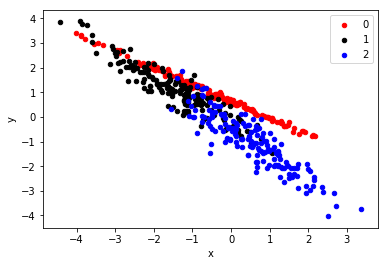

In [2]:
# Generate the dataset
X, y = make_classification(n_samples=500, n_features=4, n_classes=3, n_clusters_per_class=1, random_state=0)

# Perform a 80/20  train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# View the dataset
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0: 'red', 1: 'black', 2: 'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

## Question 1

Create a wrapper function called <i>manifold_learn()</i> that takes in a dataset, a string specifying the model and an int specifying the number of components. Your function will fit the appropriate manifold learning model based on the inputted string:

1. "LLE": LocallyLinearEmbedding with the standard method, n components, and 200 max iteration.
2. "MDS": MDS with 200 max iteration
3. "ISO": Isomap with n components
4. "TSNE": TSNE with PCA initialization, n components, and 200 max iteration

**Note**: To pass the assertions, your function needs to have the following:
- Set the <i>random_state</i> to be 0 for reproducibility and keep all other parameters as the default.
- Set the number of neighbors to be 20 for LLE and Isomap.
- In your code, if n is not specified, set it to be default of 2.

In [6]:
def manifold_learn(X, model_name, n=None):
    '''    
    Parameters
    ----------
    X: A numpy.ndarray
    model_name: A String specifying the model
    n: A int specifying the number of components
    
    Returns
    -------
    result: A sklearn.manifold.LocallyLinearEmbedding, sklearn.manifold.MDS,
            sklearn.manifold.Isomap or sklearn.manifold.TSNE instance
    '''

    num_neighbors = 20
    
    if n == None :
        n = 2
    
    if model_name == 'LLE' :
        model = LocallyLinearEmbedding(num_neighbors, n_components = n, random_state = 0, method = 'standard', max_iter = 200).fit(X)
    elif model_name == 'MDS':
        model = MDS(n_components = n, max_iter = 200, random_state = 0).fit(X)
    elif model_name == 'ISO':
        model = Isomap(n_components = n).fit(X)
    else:
        model = TSNE(n_components = n, init='pca', n_iter = 200, random_state = 0).fit(X)

    return model

In [4]:
# This might take a few minutes to run.
LLE_model = manifold_learn(X, "LLE")
LLE_model2 = manifold_learn(X, "LLE", 3)

assert_equal(isinstance(LLE_model, LocallyLinearEmbedding), True)
assert_equal(isinstance(LLE_model2, LocallyLinearEmbedding), True)
assert_equal(LLE_model.max_iter, 200)
assert_equal(LLE_model2.max_iter, 200)
assert_equal(LLE_model.n_components, 2)
assert_equal(LLE_model2.n_components, 3)
assert_equal(LLE_model.embedding_.shape, (500,2))
assert_equal(LLE_model2.embedding_.shape, (500,3))


In [7]:
# This might take a few minutes to run.
ISO_model = manifold_learn(X, "ISO")
assert_equal(isinstance(ISO_model, Isomap), True)
assert_equal(ISO_model.n_components, 2)
assert_equal(ISO_model.embedding_.shape, (500,2))


In [8]:
# This might take a few minutes to run.
MDS_model = manifold_learn(X, "MDS", 2)
TSNE_model = manifold_learn(X, "TSNE", 2)

assert_equal(isinstance(MDS_model, MDS), True)
assert_equal(isinstance(TSNE_model, TSNE), True)
assert_equal(MDS_model.embedding_.shape, (500,2))
assert_equal(TSNE_model.embedding_.shape, (500,2))


A straight-forward way to compare between the methods is seeing the separations visually.

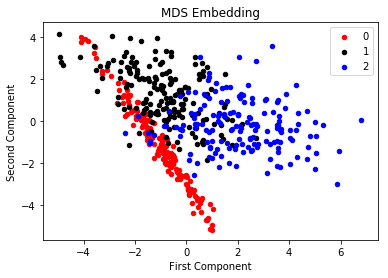

In [10]:
# Example: Visualize the MDS with the point labels to see the separation.
df = pd.DataFrame(dict(x=MDS_model.embedding_[:,0], y=MDS_model.embedding_[:,1], label=y))
colors = {0: 'red', 1: 'black', 2: 'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.title('MDS Embedding')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.show()

## Question 2

We would now like to see which manifold learning method resulted in the best separation. Create a function that takes the manifold learning model as an input and plot the visualization to see the separation. Your plot should look like that one in the above example. In order to pass all the assertions, you need to do the following:

- Make sure your function returns a _matplotlib.axes.Axes_ object.
- Set the x-axis and y-axis labels.
- Make sure you have a legend.
- Set the title for the plot depending on the model. (e.g., LLE plot be titled "LLE Embedding", MDS plot be titled "MDS Embedding", Isomap plot should have "Isomap Embedding", and TSNE plot be titled "TSNE Embedding".)

__Hint__: You may use the built-in function _isinstance()_ to check which type of model is inputted. Recall how Python does string formatting in the [documentation](https://docs.python.org/2/library/stdtypes.html#string-formatting). Note, you 

In [15]:
def plot_manifold(model):
    '''    
    Parameters
    ----------
    model: A sklearn.manifold.LocallyLinearEmbedding, sklearn.manifold.MDS,
            sklearn.manifold.Isomap or sklearn.manifold.TSNE instance
    
    Returns
    -------
    ax: A matplotlib.Axes instance.
    '''
    #predict the type of model
    if isinstance(model, LocallyLinearEmbedding) == True :
        name = "LLE Embedding"
    elif isinstance(model, MDS) == True :
        name = "MDS Embedding"
    elif isinstance(model, Isomap) == True :
        name = "Isomap Embedding"
    else:
        name = "TSNE Embedding"
    
    df = pd.DataFrame(dict(x = model.embedding_[:,0], y = model.embedding_[:,1], label=y))
    colors = {0: 'red', 1: 'black', 2: 'blue'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.title(name)
    plt.xlabel('First Component')
    plt.ylabel('Second Component')


    return ax

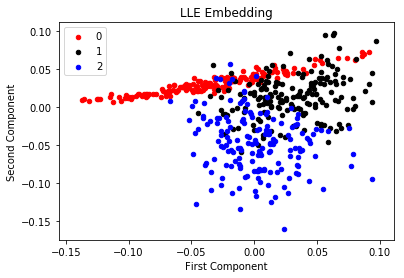

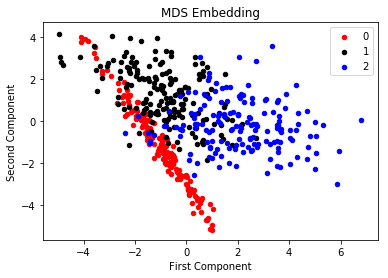

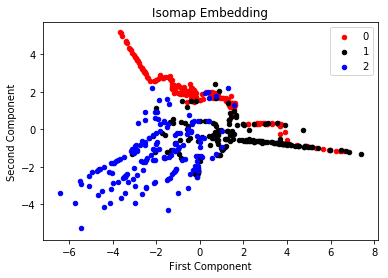

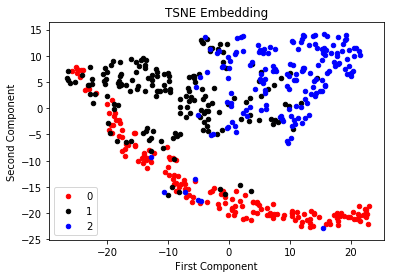

In [16]:
# Which approach had the best separation visually?
ax = plot_manifold(LLE_model)
ax1 = plot_manifold(MDS_model)
ax2 = plot_manifold(ISO_model)
ax3 = plot_manifold(TSNE_model)

In [17]:
# Check to see if an Axes object is returned
assert_is_instance(
    ax, mpl.axes.Axes,
    msg="Your function should return a matplotlib.axes.Axes object."
)

# Check if the title is set
assert_is_not(
    len(ax.title.get_text()), 0,
    msg="Your plot doesn't have a title."
)

# Check if the title is set
assert_is_not(
    ax.title.get_text(), 'LLE Embedding',
    msg="Your plot title needs to be based learning method."
)

# Check if the x-axis has a label.
assert_is_not(
    ax.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive."
)

# Check if the y-axis has a label.
assert_is_not(
    ax.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive."
)

# Check if legend exists
assert_equal(len(ax.get_legend_handles_labels()) > 0, True,
             msg="Make sure you create a legend."
)


## Question 3

The manifold embedding result is dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. Should we use __reconstruction error__ as a possible measure? 

Create a function called <i>optimal_num_neighbors()</i> which takes the data and a value specifying the max number of neighbors from 2 to _k_. Fit a _LocallyLinearEmbedding()_ model using the standard method with <i>random_state=0</i>. Your function needs to return a list of reconstruction errors and also return the number of neighbors which yields the smallest reconstruction error

__Example__: <i>optimal_num_neighbors(X, 4)</i> will fit an LLE with k=2,3,4. It should return a list of three elements and the optimal number of neighbor corresponding to the smallest value. For instance, [0.01, 0.002, 0.4] and 3.

__Hint__:
- You can get the reconstruction error using <i>modelname.reconstruction\_error\_</i> (see the [LLE Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html)).
- The optimal number of neighbor is index of the smallest value in the list plus 2 (because list index starts at 0 and we consider neighbors starting from 2).

In [18]:
def optimal_num_neighbors(X, k):
    '''    
    Parameters
    ----------
    X: A numpy.ndarray
    
    Returns
    -------
    errors: A list of the reconstruction errors
    optimal_neighbor: A int corresponding to the value of neighbors with the smallest reconstruction error
    '''
    errors = []
    for k_try in range(2, k+1):
        model = LocallyLinearEmbedding(n_neighbors=k_try, random_state=0, method='standard').fit(X)
        errors.append(model.reconstruction_error_)
    
    optimal_neighbor = np.argmin(errors)+2    
    
    return errors, optimal_neighbor

In [19]:
# To make things faster, we will create a smaller dataset.
X1, y1 = make_classification(n_samples=100, n_features=4, n_classes=2, random_state=0)

In [20]:
# Might take a few minutes to run.
min_error1, num_neighbors1 = optimal_num_neighbors(X1, 5)
assert_equal(len(min_error1), 4)
assert_equal(num_neighbors1, 2)

min_error1, num_neighbors1 = optimal_num_neighbors(X1, 3)
assert_equal(len(min_error1), 2)
assert_equal(num_neighbors1, 2)
